# Lexical overlap promedio del corpus de introducciones de la revista CELL

In [1]:
import numpy as np
import random
from nltk import sent_tokenize
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
import itertools
from scipy import spatial
import networkx as nx
import ast
import re
from joblib import Parallel, delayed
import multiprocessing
import pandas as pd
import random
import spacy
nlp = spacy.load('en')


data=open('stopwords.txt','r')
data_read = data.read()
stop_words=data_read.replace('\n',' ').split()

## lexical overlap entre oraciones

In [15]:
def lexical_overlap(sentence_i,sentence_j): ## oraciones como strings
    sentence_i=nlp(unicode(sentence_i))
    sentence_j=nlp(unicode(sentence_j))
    sentence_i=[token.lemma_ for token in sentence_i]
    sentence_j=[token.lemma_ for token in sentence_j]
    sentence_i=[w for w in sentence_i if w not in stop_words]
    sentence_j=[w for w in sentence_j if w not in stop_words]
    n=np.log(len(list(set(sentence_i))))
    m=np.log(len(list(set(sentence_j))))
    overlap=len(list(set(sentence_i).intersection(sentence_j)))/float(n+m)
    
    return overlap

def text_overlap(text):
    overlap=0
    sentences=sent_tokenize(text)
    n=len(sentences)
    pairs=list(zip(range(n),range(n)[1:]))
    for pair in pairs:
        overlap+=lexical_overlap(sentences[pair[0]],sentences[pair[1]])
    
    return overlap/float(len(pairs))

In [7]:
text_overlap('the dog killed the cat. the dog killed the cat')

1.207288813145534

## introducciones revista CELL

In [8]:
data = open('corpus_cell.json','r')
data_cell=data.read()
data_cell = ast.literal_eval(data_cell)
introductions=[' '.join(item['introduction']) for item in data_cell]
introductions=[re.sub("[\(\[].*?[\)\]]", "", item) for item in introductions]
introductions=[x for x in introductions if len(x)>0]
introductions=[' '.join([s for s in sent_tokenize(text) if len(s)>1]) for text in introductions]

In [23]:
n=multiprocessing.cpu_count()

lexical_overlap=Parallel(n_jobs=n)(delayed(text_overlap)(text) for text in introductions)

In [24]:
overlap_dict={x:[y] for x,y in zip(range(len(lexical_overlap)),lexical_overlap)}

C=pd.DataFrame(overlap_dict)
C.to_csv('overlap.csv')

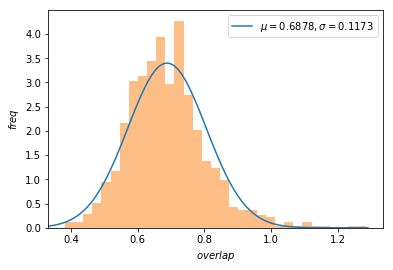

In [35]:
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy import stats  

data = np.array(lexical_overlap) 

t=scipy.stats.mstats.normaltest(data)

bins = np.arange(0.3, 1.3, 0.01) # fixed bin size

m, s = stats.norm.fit(data) 
pdf_g = norm.pdf(bins, m, s) # now get theoretical values in our interval  
plt.plot(bins, pdf_g, label='$\mu=0.6878,\sigma=0.1173$') # plot it
plt.legend(loc='best')
plt.xlim([min(data)-0.05, max(data)+0.05])
plt.hist(data, bins='auto', alpha=0.5,normed=True)
plt.xlabel('$overlap$')
plt.ylabel('$freq$')
plt.show()

In [28]:
m,s

(0.68784781723781729, 0.11730043694812982)

# Experimento con textos desordenados (introducciones de la revista CELL) 


### corpus de textos desordenados (x cada uno definimos K = 10 versiones)

In [13]:
introductions=random.sample(introductions,1000) ## seleccionamos 1000 al azar!

random_corpus={}
K=10
for i in range(len(introductions)):
    random_versions=[]
    for j in range(K):
        text_random=sent_tokenize(introductions[i])
        text_random=random.sample(text_random,len(text_random))
        text_random=' '.join(text_random)
        random_versions+=[text_random]
    random_corpus[i]=random_versions

In [16]:
text_overlap(random_corpus[0][0])

0.6453855511428185

In [17]:
overlap_random={}
for i in range(len(introductions)):
    overlap_list=[]
    for j in range(K):
        overlap_list+=[text_overlap(random_corpus[i][j])]
    overlap_random[i]=overlap_list

In [18]:
values_random=[item for sublist in overlap_random.values() for item in sublist]

C=pd.DataFrame(values_random)
C.to_csv('overlap_random.csv')




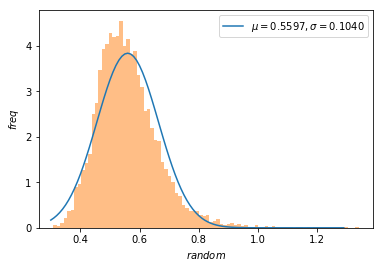

In [33]:
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy import stats  

data = np.array(values_random) 

t=scipy.stats.mstats.normaltest(data)

bins = np.arange(0.3, 1.3, 0.01) # fixed bin size

m, s = stats.norm.fit(data) 
pdf_g = norm.pdf(bins, m, s) # now get theoretical values in our interval  
plt.plot(bins, pdf_g, label='$\mu=0.5597,\sigma=0.1040$') # plot it
plt.legend(loc='best')
plt.xlim([min(data)-0.05, max(data)+0.05])
plt.hist(data, bins='auto', alpha=0.5,normed=True)
plt.xlabel('$random$')
plt.ylabel('$freq$')
plt.show()

In [34]:
m,s

(0.5597939704845889, 0.10403860357121601)

### dos distribuciones simultáneas

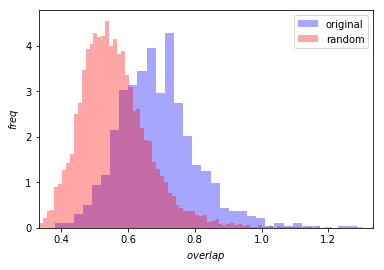

In [32]:
data = np.array(lexical_overlap) 
data_random = np.array(values_random) 

bins = np.arange(0.3, 1.3, 0.01) # fixed bin size

plt.hist(data, bins='auto', alpha=0.35,normed=True,color='blue',label='original')
plt.hist(data_random, bins='auto', alpha=0.35,normed=True,color='red',label='random')

plt.legend(loc='best')
plt.xlim([min(data)-0.05, max(data)+0.05])
plt.xlabel('$overlap$')
plt.ylabel('$freq$')
plt.show()